Hw 2, Problem 3: Lifting Map and Delaunay Triangulation

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from mpl_toolkits.mplot3d import Axes3D
import csv
import time 
from scipy.spatial import Delaunay

Part a)

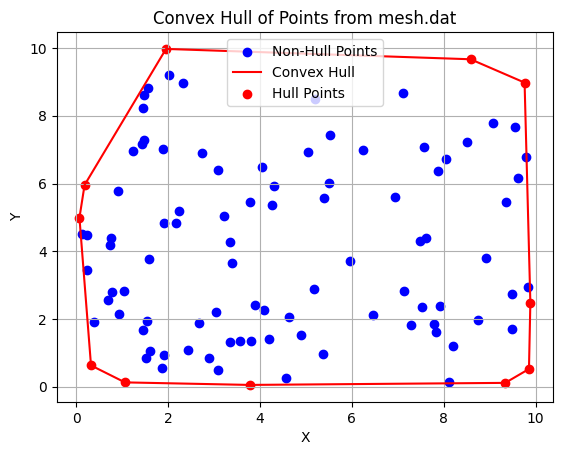

In [18]:
def get_cross_product(p1, p2, p3):
    return (p2[0] - p1[0]) * (p3[1] - p1[1]) - (p2[1] - p1[1]) * (p3[0] - p1[0])

def get_slope(p1, p2):
    if p1[0] == p2[0]:
        return float('inf')
    return (p2[1] - p1[1]) / (p2[0] - p1[0])

# 2D Graham Scan
def compute_convex_hull(points):
    # Step 1: Sort the points
    points.sort(key=lambda x: (x[0], x[1]))
    
    # Step 2: Get the start point (lowest lexicographical point)
    start = points.pop(0)
    hull = [start]

    # Step 3: Sort remaining points based on polar angle with the start point
    points.sort(key=lambda p: (get_slope(start, p), p[1], p[0]))

    # Step 4: Build the hull
    for pt in points:
        hull.append(pt)
        # Ensure convexity by checking the cross product
        while len(hull) > 2 and get_cross_product(hull[-3], hull[-2], hull[-1]) < 0:
            hull.pop(-2)
    
    return hull

def read_points_from_file(filename):
    points = []
    with open(filename, 'r') as f:
        reader = csv.reader(f, delimiter=' ')
        next(reader)  # Skip the first row (header)
        for row in reader:
            # Convert the x, y values to floats and append as a tuple
            points.append((float(row[0]), float(row[1])))
            
    return points

points = read_points_from_file('mesh.dat')
# print(points)
hull = compute_convex_hull(points)
# print(hull)

def plot_points_with_hull(points, hull):
    # Separate the points on the convex hull from the others
    hull_set = set(hull)
    non_hull_points = [pt for pt in points if pt not in hull_set]
    
    # Plot all points (non-hull points in one color)
    x_non_hull, y_non_hull = zip(*non_hull_points) if non_hull_points else ([], [])
    plt.scatter(x_non_hull, y_non_hull, color='blue', label='Non-Hull Points')
    
    # Plot the convex hull points (different color, connected by lines)
    x_hull, y_hull = zip(*hull)
    plt.plot(x_hull + (x_hull[0],), y_hull + (y_hull[0],), color='red', label='Convex Hull')
    plt.scatter(x_hull, y_hull, color='red', marker='o', label='Hull Points')
    
    # Add labels and title
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Convex Hull of Points from mesh.dat')
    plt.legend()
    plt.grid(True)
    plt.show()
    
plot_points_with_hull(points, hull)

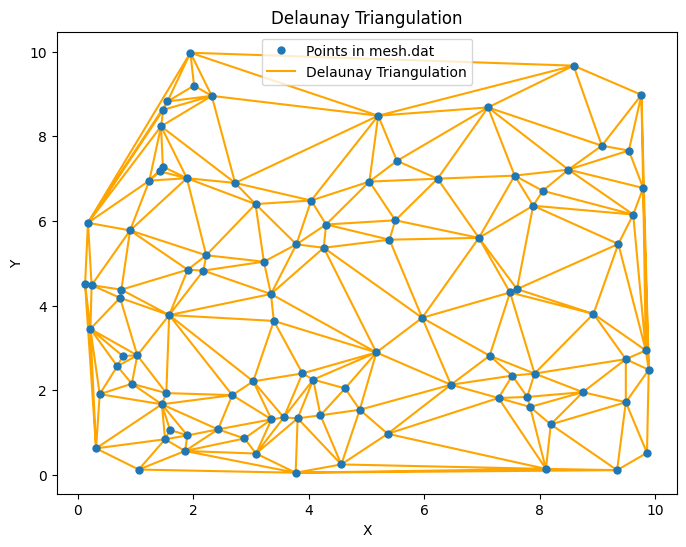

In [19]:
points_np = np.array(points)

# Create the Delaunay triangulation
triangulation = Delaunay(points_np)

# Plot the points and the Delaunay triangulation
plt.figure(figsize=(8, 6))
plt.plot(points_np[:, 0], points_np[:, 1], 'o', markersize=5, label='Points in mesh.dat')
plt.triplot(points_np[:, 0], points_np[:, 1], triangulation.simplices, color='orange', label='Delaunay Triangulation')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Delaunay Triangulation')
plt.legend()
plt.show()

Part b)

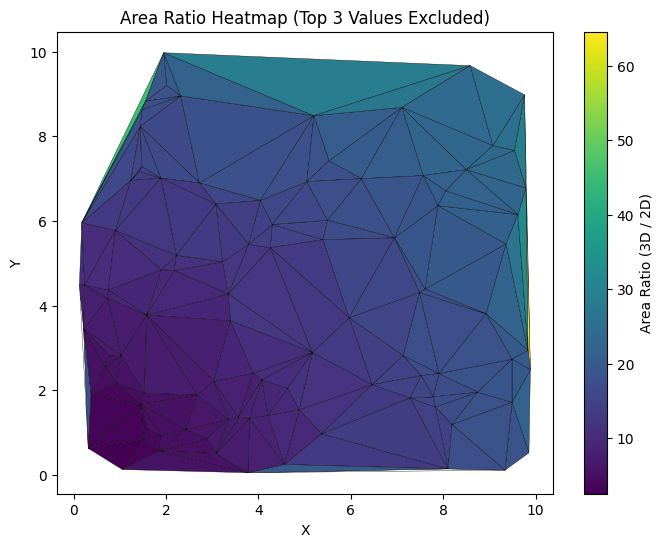

In [46]:
# Lifting map function
def lifting_map(x, y):
    return x**2 + y**2

# Triangle area functions
def triangle_area_2d(p1, p2, p3):
    return 0.5 * abs(p1[0] * (p2[1] - p3[1]) + p2[0] * (p3[1] - p1[1]) + p3[0] * (p1[1] - p2[1]))

def triangle_area_3d(p1, p2, p3):
    v1 = np.array([p2[0] - p1[0], p2[1] - p1[1], p2[2] - p1[2]])
    v2 = np.array([p3[0] - p1[0], p3[1] - p1[1], p3[2] - p1[2]])
    cross_product = np.cross(v1, v2)
    return 0.5 * np.linalg.norm(cross_product)

# Calculate area ratios for each triangle
area_ratios = np.zeros(len(triangulation.simplices))
for i, simplex in enumerate(triangulation.simplices):
    p1 = points_np[simplex[0]]
    p2 = points_np[simplex[1]]
    p3 = points_np[simplex[2]]
    
    area_2d = triangle_area_2d(p1, p2, p3)
    
    p1_3d = (p1[0], p1[1], lifting_map(p1[0], p1[1]))
    p2_3d = (p2[0], p2[1], lifting_map(p2[0], p2[1]))
    p3_3d = (p3[0], p3[1], lifting_map(p3[0], p3[1]))
    
    area_3d = triangle_area_3d(p1_3d, p2_3d, p3_3d)
    
    area_ratios[i] = area_3d / area_2d

# print(len(area_ratios))
# print(len(triangulation.simplices))
# print(area_ratios)
# print(max(area_ratios))

# Step 1: Set the number of top values to exclude
n = 3  # Adjust as needed

# Step 2: Find the top n highest values in area_ratios
top_n_values = np.partition(area_ratios, -n)[-n:]  # This gives the top n values

# Step 3: Mask these top n values by replacing them with NaN
area_ratios_filtered = np.copy(area_ratios)
for value in top_n_values:
    area_ratios_filtered[area_ratios == value] = np.nan

# Step 4: Plot the area ratio heatmap
plt.figure(figsize=(8, 6))
plt.tripcolor(points_np[:, 0], points_np[:, 1], triangulation.simplices, facecolors=area_ratios_filtered, cmap='viridis', edgecolors='k')
plt.colorbar(label='Area Ratio (3D / 2D)')
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'Area Ratio Heatmap (Top {n} Values Excluded)')
plt.show()

Part c)

In [48]:
# Compute the coefficients of the induced metric at a point (x, y)
def induced_metric(x, y):
    E = 1 + 4*x**2
    F = 2*x*y
    G = 1 + 4*y**2
    return E, F, G

# Calculate the induced metric for each point
metrics = [induced_metric(x, y) for x, y in points_np]

# Print the metrics for each point
for i, (x, y) in enumerate(points_np):
    E, F, G = metrics[i]
    print(f"Point ({x}, {y}): E = {E}, F = {F}, G = {G}")

Point (0.318775, 0.628921): E = 1.4064700024999999, F = 0.4009685835499999, G = 2.5821664969639997
Point (0.220598, 3.450224): E = 1.1946539104159999, F = 1.522225027904, G = 48.616182600704
Point (0.381927, 1.908477): E = 1.583472933316, F = 1.457797790358, G = 15.569137838116
Point (0.128699, 4.507505): E = 1.066253730404, F = 1.16022277199, G = 82.27040530010001
Point (1.057869, 0.128336): E = 5.476347284644, F = 0.271525351968, G = 1.065880515584
Point (0.686874, 2.569727): E = 2.8871835675039996, F = 3.5301573267959996, G = 27.413987418115997
Point (0.937792, 2.15556): E = 4.517815341056, F = 4.04293384704, G = 19.5857556544
Point (0.780256, 2.810086): E = 3.435197702144, F = 4.385172924032, G = 32.586333309584006
Point (0.24177, 4.484384): E = 1.2338109316, F = 2.1683790393600004, G = 81.43879943782402
Point (1.513863, 0.843987): E = 10.167124731076, F = 2.555361383562, G = 3.8492562246760005
Point (1.598117, 1.064985): E = 11.215911782756, F = 3.4039412664900004, G = 5.536772200

Part d)

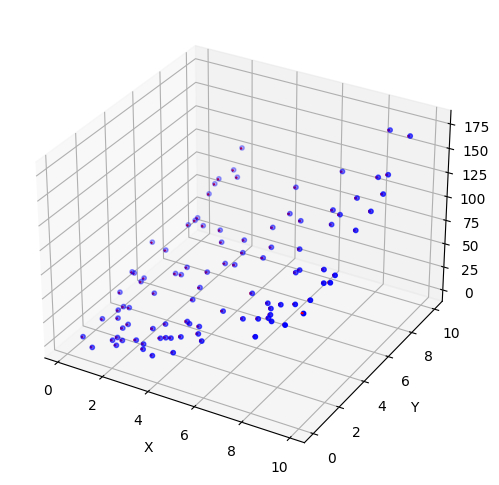

In [49]:
# Compute the normal vector at a point (x, y) on the surface
def surface_normal(x, y):
    # Tangent vectors
    dx = np.array([1, 0, 2*x])
    dy = np.array([0, 1, 2*y])
    
    # Cross product to get the normal vector
    normal = np.cross(dx, dy)
    
    # Normalize the normal vector
    normal = normal / np.linalg.norm(normal)
    
    return normal

# Let's assume points_np contains the x and y coordinates of your points
# points_np = np.array([ (x, y) for x, y in points ])  # Replace with actual points

# Create an empty plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the mesh
x_vals = points_np[:, 0]
y_vals = points_np[:, 1]
z_vals = lifting_map(x_vals, y_vals)
ax.scatter(x_vals, y_vals, z_vals, color='b', marker='o', s=10)

# Calculate and plot the surface normals
normals = [surface_normal(x, y) for x, y in points_np]
for i, (x, y) in enumerate(points_np):
    normal = normals[i]
    ax.quiver(x, y, lifting_map(x, y), normal[0], normal[1], normal[2], length=0.1, color='r', normalize=True)

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()